<a href="https://colab.research.google.com/github/omarrajaa/AI-4-Climate-Change-Identifying-plants-disease/blob/main/AI_4_Climate_Change_(Identifying_plants_disease).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Identifying plants disease project </center>

first we need to import libraries  and put random state

In [1]:
from sklearn import metrics

In [ ]:
#libraties
!pip install gradio
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
import os
import gradio as gr
#random state
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

## **1. Download and Read data**

### 1.1 download

In [ ]:
!wget 'https://docs.google.com/uc?export=download&id=1uoovX3TrkZrOIS3ARsWZEXEMCORWW1RK&confirm=t'
os.rename('uc?export=download&id=1uoovX3TrkZrOIS3ARsWZEXEMCORWW1RK&confirm=t', 'data_of_plants_leaf_diseases.zip')
!unzip data_of_plants_leaf_diseases.zip

### 1.2 read


In [4]:
from pathlib import Path
import imghdr

img_link=list(Path("/content/data_of_plants_leaf_diseases").glob(r'**/*.jpg'))

count_num=0
for lnk in img_link:
    binary_img=open(lnk,'rb')
    find_img=tf.compat.as_bytes('JFIF') in binary_img.peek(10)
    if not find_img:
        count_num+=1
        os.remove(str(lnk))
print('Total %d pcs image delete from Dataset' % count_num)
!rm -rf /content/data_of_plants_leaf_diseases/cotton__healthy/h420.webp

Total 27 pcs image delete from Dataset


In [5]:
def read_dataset(path):  # path of data
    x = []  # images
    y = []  # labels

    # we will use os.listdir to read the contents of the folder
    labels = os.listdir(path)

    # iterate over the labels
    for label in labels:
        # we join the label to the path to get the path to the class folder which contains the images
        label_dir = os.path.join(path, label)

        # we will use os.listdir again to read the contents of the class folders (i.e., the images)
        images = os.listdir(label_dir)

        # iterate over the images
        for image in os.listdir(label_dir):
            # we join the image name to the path to get the path to the image
            image_path = os.path.join(
                label_dir, image
            ) 

            # append the image path and the label to the lists
            x.append(image_path)
            y.append(label)

    # return a dataframe with the image paths and labels
    return pd.DataFrame({"image": x, "label": y})


# read the data
data_df = read_dataset("data_of_plants_leaf_diseases")

In [6]:
train_df , validation_df = model_selection.train_test_split(data_df,test_size= 0.2 , random_state=seed )

In [7]:
label_to_index = dict(zip(pd.unique(train_df["label"]) , [item for item in range(35)]))
index_to_label = dict(zip([item for item in range(35)] ,pd.unique(train_df["label"])))

## **2. processing data (pipelines)**

In [8]:
def image_to_resnet_tensor(x, y):
    # read the image from the path
    img = tf.io.read_file(x)
    # decode the image
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image
    img = tf.image.resize(img, [224, 224])
    # normalize the image
    img = img/225.0
    return img, y

def label_to_one_hot(x, y):
  y = tf.one_hot(y, depth=len(pd.unique(train_df["label"])))
  return x, y


def image_augmentation(x, y):
    # randomly flip the image horizontally
    img = tf.image.random_flip_left_right(x)
    # randomly flip the image vertically
    img = tf.image.random_flip_up_down(img)
    # randomly change the brightness of the image
    img = tf.image.random_brightness(img, max_delta=0.2)
    # clip the image to be between 0 and 1
    img = tf.clip_by_value(img, 0, 1)
    return img, y

train_df["label"] = train_df["label"].map(label_to_index)
validation_df["label"] = validation_df["label"].map(label_to_index)

In [9]:
def tf_dataset_creator(x, y, training=False):
    # create a tf.data.Dataset from the input output pairs
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    # map the image paths to tensors using the new resnet preprocessing function
    dataset = dataset.map(image_to_resnet_tensor)
    # map the labels to one-hot encoded vectors
    dataset = dataset.map(label_to_one_hot)
    # if training, apply image augmentation. Remember that we never apply image augmentation to the validation set
    if training:
        dataset = dataset.map(image_augmentation)
    # shuffle the dataset
    dataset = dataset.shuffle(1000)
    # batch the dataset
    dataset = dataset.batch(32)
    # auto tune data
    dataset = dataset.prefetch(tf.data.AUTOTUNE) 
    return dataset

train_dataset = tf_dataset_creator(train_df["image"], train_df["label"], training=True)
validation_dataset = tf_dataset_creator(validation_df["image"], validation_df["label"])

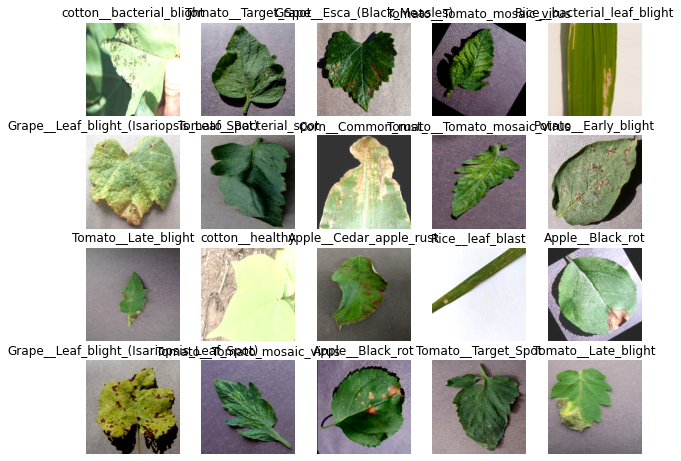

In [10]:
for image, label in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(20):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image[i].numpy())
        plt.title(index_to_label[np.argmax(label[i].numpy())])
        plt.axis("off")

## **3.model**

### **3.1 model building**

In [11]:
model_A = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3) , padding="same" ,input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((4,4)),
 
    tf.keras.layers.Conv2D(128, (3,3), padding="same" ,input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((4,4)),
 
    tf.keras.layers.Conv2D(256, (3,3), padding="same" ,input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((4,4)),
 
    tf.keras.layers.Conv2D(512, (3,3), padding="same" ,input_shape=(224, 224, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((2,2)),
 
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(units=512),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(len(pd.unique(train_df["label"])), activation='softmax'),
])

model_A.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 56, 56, 128)      5

In [12]:
model_A.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001,ema_momentum=0.9999),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

h= model_A.fit(train_dataset, epochs=30, validation_data=validation_dataset, callbacks=[early_stopping])

h

Epoch 1/30
1256/1256 [==============================] - 154s 105ms/step - loss: 1.9257 - accuracy: 0.4968 - val_loss: 1.1152 - val_accuracy: 0.7113
Epoch 2/30
1256/1256 [==============================] - 125s 98ms/step - loss: 1.0386 - accuracy: 0.7346 - val_loss: 0.7466 - val_accuracy: 0.8054
Epoch 3/30
1256/1256 [==============================] - 121s 95ms/step - loss: 0.7452 - accuracy: 0.8114 - val_loss: 0.5689 - val_accuracy: 0.8521
Epoch 4/30
1256/1256 [==============================] - 122s 96ms/step - loss: 0.5785 - accuracy: 0.8555 - val_loss: 0.4610 - val_accuracy: 0.8755
Epoch 5/30
1256/1256 [==============================] - 122s 96ms/step - loss: 0.4693 - accuracy: 0.8856 - val_loss: 0.3929 - val_accuracy: 0.8947
Epoch 6/30
1256/1256 [==============================] - 125s 98ms/step - loss: 0.3896 - accuracy: 0.9076 - val_loss: 0.3458 - val_accuracy: 0.9061
Epoch 7/30
1256/1256 [==============================] - 121s 95ms/step - loss: 0.3297 - accuracy: 0.9232 - val_loss: 

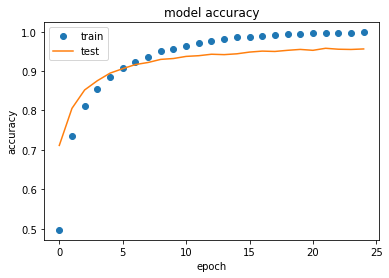

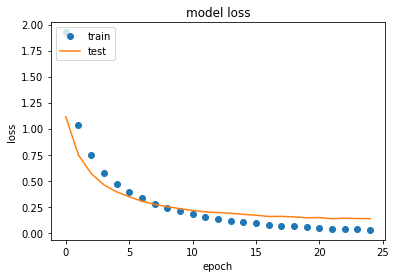

In [13]:
plt.plot(h.history['accuracy'],'o')
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'],'o')
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


### **3.2 save and load model**

In [ ]:
# to save model 
model_A.save("Doctor_Plant.h5")

In [ ]:
# load it 
model_A = tf.keras.models.load_model('Doctor_Plant.h5')

## **4.interface** 

In [ ]:
def classify_image(img):
  img = img.reshape((-1, 224, 224, 3))
  img = img/225.0
  prediction = model_A.predict(img)
  confidences = index_to_label[np.argmax(prediction)]
  return confidences

gr.Interface(
    fn=classify_image, 
    inputs=gr.inputs.Image(shape=(224, 224)),
    outputs=gr.inputs.Textbox(label="P D")
    ).launch(debug=True,share=True)

/usr/local/lib/python3.9/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.9/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://26dea88050d313728a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


1/1 [==============================] - 0s 471ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://26dea88050d313728a.gradio.live
